In [207]:
from utils import *
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import galois
from scipy.sparse import coo_matrix, hstack
import json
import datetime

## Utils

In [3]:
def rref_with_pivots(A, v, x = None):
    """
    Perform Gaussian elimination to find the reduced row echelon form (RREF).
    Also identifies the pivot columns.
    Also reduces a vector to keep a linear system invariant.
    
    Parameters
    ----------
    A : Galois field array
        Galois field matrix to row reduce
        
    Returns
    -------
    A_rref : Galois field array
        Row-reduced form of A
    pivots : list
        Indices of pivot columns
    """
    # Get a copy to avoid modifying the original
    A_rref = A.copy()
    v_rref = v.copy()
    m, n = A_rref.shape
    assert v.shape == (m,)
    # assert (A_rref @ x == v_rref).all()
    
    # Track the pivot positions
    pivot_cols = []
    pivot_rows = []
    
    # Iterate through columns
    for c in range(n):
        # Find pivot in column c
        for r in range(m):
            if A_rref[r, c] != 0 and r not in pivot_rows:
                break
        else:
            continue

        # Record this column as a pivot column
        pivot_cols.append(c)
        pivot_rows.append(r)
        
        # Scale the pivot row to make the pivot element 1
        pivot = A_rref[r, c]
        A_rref[r] = A_rref[r] / pivot
        v_rref[r] = v_rref[r] / pivot
        
        # Eliminate other elements in the pivot column
        for i in range(m):
            if i != r and A_rref[i, c] != 0:
                v_rref[i] = v_rref[i] - A_rref[i,c] * v_rref[r]
                A_rref[i] = A_rref[i] - A_rref[i, c] * A_rref[r]
        
        # If we've exhausted all rows, we're done
        if len(pivot_rows) == m:
            break
    
    # if len(pivot_rows) < A.shape[0]:
    #     print("Matrix is not full rank.")

    return A_rref[sorted(pivot_rows)], v_rref[sorted(pivot_rows)], pivot_cols

In [4]:
def dijkstra_osd_decode(self, syndrome_history, prior, h_eff, debug = False):
    """Decode the syndrome using D+OSD.
    
    Parameters
    ----------
    syndrome_history : nd.array
        The syndrome of the error.
    prior : nd.array
        The probability of each error mechanism.
    h_eff : nd.array
        The effective parity check matrix, where columns = error mechanism and rows = syndrome (flagged stabilisers).

    Returns
    -------
    error : nd.array
        The estimated error.
    """
    if not isinstance(syndrome_history, np.ndarray):
        raise TypeError('syndrome must be a numpy array')
    if not isinstance(prior, np.ndarray):
        raise TypeError('prior must be a np.ndarray')

    field = self.field
    qubits_dict = self.qubits_dict
    data_qubits, x_checks, z_checks = self.data_qubits, self.x_checks, self.z_checks

    m, n = h_eff.shape

    # Mini-Dijkstra
    check_distances = np.ones(m) * n
    error_distances = np.ones(n) * n

    # Set the distance each detector is from an error
    for c in syndrome_history.nonzero()[0]:
        check_distances[c] = 0

    update_made = True
    while update_made:
        update_made = False
        for c in range(m):
            current_distance = check_distances[c]
            for e in np.nonzero(h_eff[c])[0]:
                if current_distance + 1 < error_distances[e]:
                    error_distances[e] = current_distance + 1
                    update_made = True

        for e in range(n):
            current_distance = error_distances[e]
            for c in np.nonzero(h_eff[:,e])[0]:
                if current_distance + 1 < check_distances[c]:
                    check_distances[c] = current_distance + 1
                    update_made = True

    certainties = error_distances

    # Sort errors by how certain we are of their values (most to least)
    col_rank_perm = np.argsort(certainties)
    col_rank_inv_perm = np.empty_like(col_rank_perm)
    col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

    # Create Galois field elements
    GF = galois.GF(field)
    
    # Convert H and syndrome to Galois field arrays
    H_gf = GF(h_eff.copy())
    syndrome_gf = GF(syndrome_history.copy())
    
    # Order the columns of h_gf and prior according to the ranking
    H_ordered_gf = H_gf[:, col_rank_perm]
    priors_perm = prior[col_rank_perm]

    # Find the reduced row echelon form (RREF) and identify pivot columns
    H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
    m_ind = H_rref_gf.shape[0]
    non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

    # Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
    P = H_rref_gf[:, pivot_cols]
    assert P.shape == (m_ind, m_ind)
    B = H_rref_gf[:, non_pivot_cols]

    def sln_from(g):
        assert g.shape == (n - m_ind,)
        remainder =  syndrome_rref_gf - B @ g
        fix = np.linalg.solve(P, remainder)
        assert (P @ fix + B @ g == syndrome_rref_gf).all()

        score = 0
        sln = GF.Zeros(n)
        # Find prob of basis set
        for i in range(m_ind):
            p = priors_perm[pivot_cols[i], fix[i]]
            sln[pivot_cols[i]] = fix[i]
            if p > 0:
                score += np.log(p)
            else:
                p -= 1000
        
        for i in range(n - m_ind):
            p = priors_perm[non_pivot_cols[i], g[i]]
            sln[non_pivot_cols[i]] = g[i]
            if p > 0:
                score += np.log(p)
            else:
                p -= 1000

        # Check sln makes correct syndrome
        assert (H_rref_gf @ sln == syndrome_rref_gf).all()
        assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()
    
        return np.array(sln[col_rank_inv_perm]), score

    # OSD_0 solution
    best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
    pivot_col_labels = {col_rank_perm[c]: int(error_distances[col_rank_perm[c]]) for c in pivot_cols}
    
    # print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')
    
    return best_solution

## Experiment 1: Qudit Toric Code under Code Capacity (varying distance)

In [ ]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 10
# results_cap_qubit = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = results_cap_qubit[d]
    for ind, p in enumerate(np.logspace(-3, -1, 20)[3:6]):
        failures = 0
        num_trials = 0
        if d == 5:
            if p < 0.002:
                res.append(np.inf)
                continue
        if d == 7:
            if p < 0.003:
                res.append(np.inf)
                continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lz) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        res[ind+3] = num_trials
        print(f'Finished p={p} for d={d}')
    print(f'Completed d={d}')
    results_cap_qubit[d] = res

Found 1 / 10, with num_trials : 552
Found 2 / 10, with num_trials : 1769
Found 3 / 10, with num_trials : 4253
Found 4 / 10, with num_trials : 4759
Found 5 / 10, with num_trials : 4920
Found 6 / 10, with num_trials : 5581
Found 7 / 10, with num_trials : 7602
Found 8 / 10, with num_trials : 7819
Found 9 / 10, with num_trials : 11330
Found 10 / 10, with num_trials : 13471
Finished p=0.001623776739188721 for d=7
Completed d=7


In [226]:
results_cap_qubit

{3: [56086,
  33751,
  31160,
  26242,
  16380,
  14568,
  10186,
  9096,
  6300,
  5155,
  3740,
  3090,
  2451,
  1694,
  1218,
  910,
  656,
  536,
  394,
  308],
 5: [58090,
  27627,
  27949,
  135376,
  102331,
  63479,
  40411,
  29084,
  16645,
  8727,
  6208,
  3383,
  2380,
  1438,
  911,
  757,
  483,
  345,
  236,
  191],
 7: [inf,
  inf,
  13472,
  10380,
  5719,
  50926,
  20708,
  14464,
  11397,
  6149,
  3730,
  2651,
  1604,
  1063,
  699,
  521,
  355,
  254,
  187,
  167],
 9: [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  9818,
  6785,
  3069,
  2274,
  1267,
  1102,
  644,
  393,
  256,
  179,
  110,
  103,
  93,
  70]}

In [ ]:
def process_results(results, num_failures, small_num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

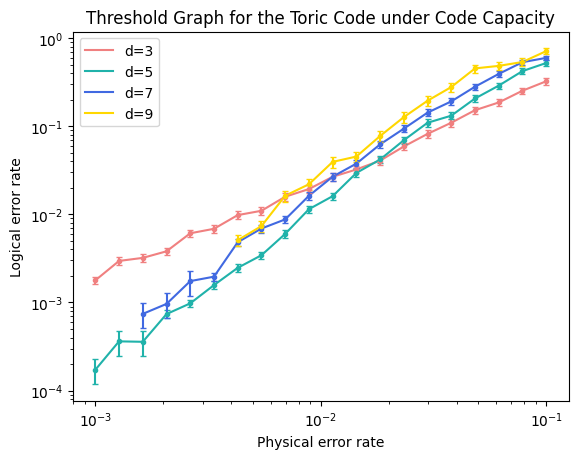

In [227]:
# Plotting

x = np.logspace(-3, -1, 20)
num_failures = {3 : 100, 5 : np.array(3*[10] + 17*[100]), 7 : np.array(5*[10] + 15*[100]), 9 : np.array(6*[10] + 14*[50])}
plot_results, plot_error_bars = process_results(results_cap_qubit, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[:], plot_results[5][:], color='lightseagreen')
plt.loglog(x[2:], plot_results[7][2:], color='royalblue')
plt.loglog(x[6:], plot_results[9][6:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[:], plot_results[5][:], yerr=plot_error_bars[5][:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[2:], plot_results[7][2:], yerr=plot_error_bars[7][2:], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x[6:], plot_results[9][6:], yerr=plot_error_bars[9][6:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

In [87]:
results_cap_qubit

{3: [0.001,
  0.003,
  0.005,
  0.003,
  0.007,
  0.007,
  0.009,
  0.01,
  0.012,
  0.024,
  0.028,
  0.03,
  0.047,
  0.07,
  0.074,
  0.106,
  0.157,
  0.195,
  0.26,
  0.32],
 5: [0.0,
  0.0,
  0.0,
  0.003,
  0.004,
  0.0,
  0.004,
  0.003,
  0.003,
  0.014,
  0.021,
  0.027,
  0.047,
  0.061,
  0.105,
  0.15,
  0.217,
  0.313,
  0.443,
  0.524],
 7: [0.0,
  0.002,
  0.0,
  0.002,
  0.002,
  0.001,
  0.002,
  0.006,
  0.009,
  0.015,
  0.032,
  0.035,
  0.079,
  0.089,
  0.135,
  0.206,
  0.289,
  0.403,
  0.541,
  0.615],
 9: [0.0,
  0.0,
  0.0,
  0.001,
  0.004,
  0.006,
  0.001,
  0.005,
  0.01,
  0.028,
  0.035,
  0.05,
  0.077,
  0.131,
  0.175,
  0.249,
  0.353,
  0.471,
  0.593,
  0.666]}

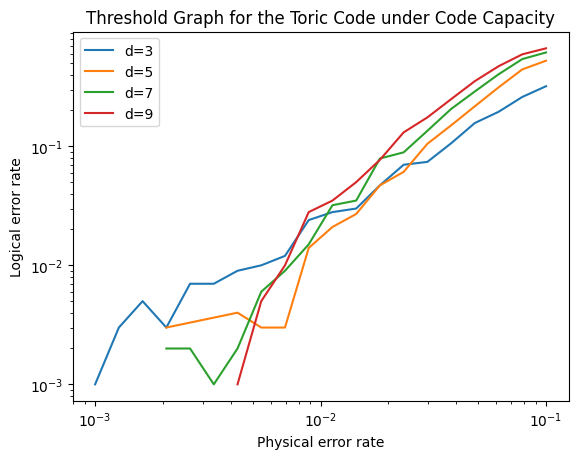

In [104]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qubit[3])
plt.loglog(np.append(x[3:4], x[6:]), np.append(results_cap_qubit[5][3:4], results_cap_qubit[5][6:]))
plt.loglog(x[3:], results_cap_qubit[7][3:])
plt.loglog(x[6:], results_cap_qubit[9][6:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

In [5]:
# Code capacity model for qudit (field=3) Toric code with varying distance

field = 3

a = Polynomial(field, np.array([[1, 0], [field-1, 0]]))
b = Polynomial(field, np.array([[1, field-1], [0, 0]]))

failures = 0
num_trials = 1000
results_cap_qudit_3 = {}

for d in [3, 5, 7, 9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = []
    for p in np.logspace(-3, -1, 20):
        failures = 0
        for _ in range(num_trials):
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
        res.append(failures/num_trials)
    print(f'Completed d={d}')
    results_cap_qudit_3[d] = res

Completed d=3
Completed d=5
Completed d=7
Completed d=9


In [63]:
results_cap_qudit_3

{3: [0.007,
  0.006,
  0.011,
  0.011,
  0.019,
  0.013,
  0.01,
  0.023,
  0.024,
  0.033,
  0.04,
  0.055,
  0.064,
  0.098,
  0.118,
  0.175,
  0.231,
  0.288,
  0.344,
  0.448],
 5: [0.0,
  0.0,
  0.001,
  0.0,
  0.001,
  0.002,
  0.003,
  0.001,
  0.011,
  0.015,
  0.016,
  0.03,
  0.052,
  0.075,
  0.133,
  0.162,
  0.274,
  0.363,
  0.484,
  0.621],
 7: [0.0,
  0.0,
  0.001,
  0.0,
  0.002,
  0.002,
  0.004,
  0.005,
  0.01,
  0.022,
  0.029,
  0.038,
  0.068,
  0.105,
  0.158,
  0.236,
  0.314,
  0.464,
  0.617,
  0.716],
 9: [0.0,
  0.002,
  0.001,
  0.001,
  0.0,
  0.0,
  0.003,
  0.007,
  0.014,
  0.022,
  0.038,
  0.055,
  0.061,
  0.146,
  0.214,
  0.302,
  0.426,
  0.502,
  0.689,
  0.773]}

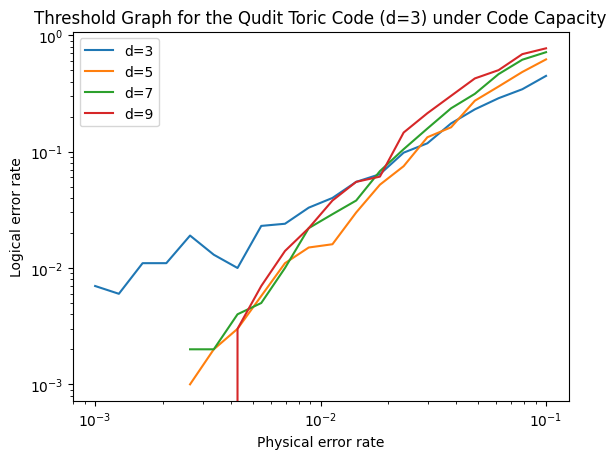

In [54]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qudit_3[3])
plt.loglog(np.append(x[4:7], x[8:]), np.append(results_cap_qudit_3[5][4:7], results_cap_qudit_3[5][8:]))
plt.loglog(x[4:], results_cap_qudit_3[7][4:])
plt.loglog(x[5:], results_cap_qudit_3[9][5:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (d=3) under Code Capacity');

In [7]:
# Code capacity model for qudit (field=5) Toric code with varying distance

field = 5

a = Polynomial(field, np.array([[1, 0], [field-1, 0]]))
b = Polynomial(field, np.array([[1, field-1], [0, 0]]))

failures = 0
num_trials = 1000
results_cap_qudit_5 = {}

for d in [3, 5, 7, 9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = []
    for p in np.logspace(-3, -1, 20):
        failures = 0
        for _ in range(num_trials):
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
        res.append(failures/num_trials)
    print(f'Completed d={d}')
    results_cap_qudit_5[d] = res

Completed d=3
Completed d=5
Completed d=7
Completed d=9


In [64]:
results_cap_qudit_5

{3: [0.005,
  0.006,
  0.007,
  0.006,
  0.005,
  0.012,
  0.012,
  0.022,
  0.027,
  0.041,
  0.054,
  0.068,
  0.076,
  0.092,
  0.133,
  0.184,
  0.222,
  0.292,
  0.349,
  0.459],
 5: [0.0,
  0.0,
  0.0,
  0.001,
  0.0,
  0.001,
  0.003,
  0.005,
  0.009,
  0.023,
  0.022,
  0.036,
  0.044,
  0.071,
  0.111,
  0.175,
  0.249,
  0.381,
  0.506,
  0.661],
 7: [0.0,
  0.0,
  0.0,
  0.001,
  0.002,
  0.001,
  0.006,
  0.012,
  0.008,
  0.015,
  0.019,
  0.045,
  0.07,
  0.118,
  0.165,
  0.256,
  0.341,
  0.492,
  0.638,
  0.785],
 9: [0.002,
  0.001,
  0.001,
  0.0,
  0.003,
  0.005,
  0.007,
  0.007,
  0.019,
  0.024,
  0.037,
  0.059,
  0.083,
  0.136,
  0.197,
  0.299,
  0.399,
  0.594,
  0.733,
  0.845]}

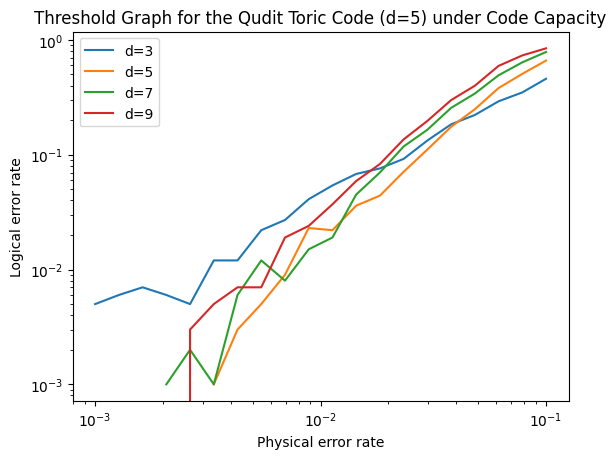

In [62]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qudit_5[3])
plt.loglog(x[5:], results_cap_qudit_5[5][5:])
plt.loglog(x[3:], results_cap_qudit_5[7][3:])
plt.loglog(x[3:], results_cap_qudit_5[9][3:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (d=5) under Code Capacity');

## Experiment 2: Qudit Toric Code under Code Capacity (varying field)

In [105]:
# Compare dimensions

results_cap_all_qudits = {}
results_cap_all_qudits[2] = results_cap_qubit[7]
results_cap_all_qudits[3] = results_cap_qudit_3[7]
results_cap_all_qudits[5] = results_cap_qudit_5[7]

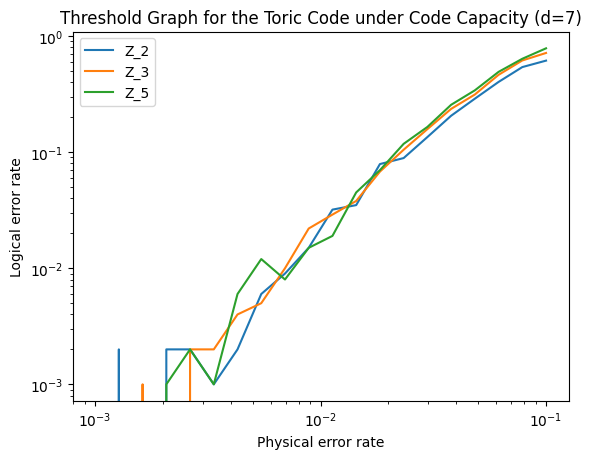

In [108]:
# Plotting

x = np.logspace(-3, -1, 20)
for field in [2, 3, 5]:
    plt.loglog(x, results_cap_all_qudits[field])
plt.legend(['Z_2', 'Z_3', 'Z_5'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity (d=7)');

## Experiment 3: Qudit BB under Code Capacity

In [ ]:
# [[72, 12, 6]]

a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb0 = BivariateBicycle(a, b, 6, 6, 1)

In [73]:
# [[90, 8, 10]]

a = Polynomial(2, np.array([[1], [0], [1], [0], [0], [0], [0], [1]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb1 = BivariateBicycle(a, b, 3, 15, 1)

In [58]:
# [[144, 12, 12]] Gross Code

a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb2 = BivariateBicycle(a, b, 6, 12, 1)

In [ ]:
failures = 0
num_trials = 500
results_cap_qudit_ibm = []

for bb in [bb0, bb1, bb2]:
    lz = bb.z_logicals
    res = []
    for p in np.logspace(-3, -1, 20):
        failures = 0
        for _ in range(num_trials):
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lz) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
        res.append(failures/num_trials)
    print(f'Completed bb={bb}')
    results_cap_qudit_ibm.append(res)

Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 1x^3y^0 + 0x^3y^1 + 0x^3y^2
b(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
Completed bb=Bivariate Bicycle code for
a(x, y) = 1x^0y^0 + 0x^1y^0 + 1x^2y^0 + 0x^3y^0 + 0x^4y^0 + 0x^5y^0 + 0x^6y^0 + 1x^7y^0
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^3y^0 + 0x^3y^1 + 0x^3y^2 + 0x^4y^0 + 0x^4y^1 + 0x^4y^2 + 0x^5y^0 + 0x^5y^1 + 0x^5y^2 + 0x^6y^0 + 0x^6y^1 + 0x^6y^2 + 0x^7y^0 + 0x^7y^1 + 0x^7y^2 + 0x^8y^0 + 0x^8y^1 + 0x^8y^2 + 1x^9y^0 + 0x^9y^1 + 0x^9y^2
Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 

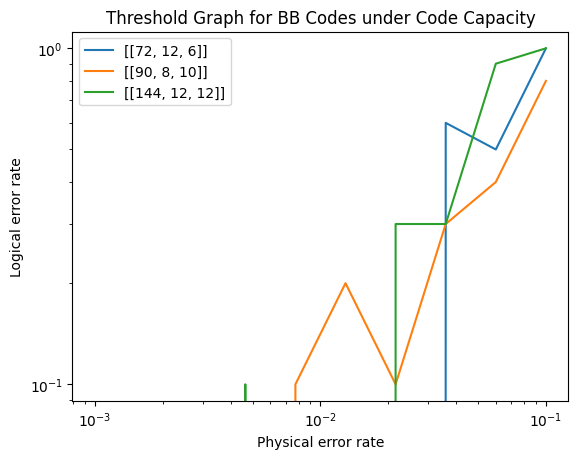

In [ ]:
# Plotting

x = np.logspace(-3, -1, 20)
for d in range(3):
    plt.loglog(x, results_cap_qudit_ibm[d])
plt.legend(['[[72, 12, 6]]', '[[90, 8, 10]]', '[[144, 12, 12]]'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for BB Codes under Code Capacity');

## Experiment 4: Qudit Gross Code esque under Code Capacity (varying field)

In [66]:
# Gross code-esque

a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg0 = BivariateBicycle(a, b, 6, 6, 1)

In [67]:
a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg1 = BivariateBicycle(a, b, 6, 6, 1)

In [68]:
a = Polynomial(5, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(5, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg2 = BivariateBicycle(a, b, 6, 6, 1)

In [74]:
# Code capacity model for qudit Gross code with varying field

failures = 0
num_trials = 1000
results_cap_qudit_gross2 = []

for bb in [bbg1, bbg2]:
    lz = bb.z_logicals
    res = []
    field = bb.field
    for p in np.logspace(-3, -1, 20):
        failures = 0
        for _ in range(num_trials):
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
        res.append(failures/num_trials)
    print(f'Completed bb={bb}')
    results_cap_qudit_gross2.append(res)

Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 1x^3y^0 + 0x^3y^1 + 0x^3y^2
Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 1x^3y^0 + 0x^3y^1 + 0x^3y^2


In [81]:
results_cap_qudit_gross

[[0.001,
  0.003,
  0.001,
  0.003,
  0.004,
  0.009,
  0.013,
  0.035,
  0.024,
  0.047,
  0.083,
  0.123,
  0.151,
  0.259,
  0.371,
  0.491,
  0.616,
  0.778,
  0.896,
  0.956],
 [0.002,
  0.0,
  0.0,
  0.005,
  0.006,
  0.004,
  0.004,
  0.007,
  0.025,
  0.029,
  0.045,
  0.088,
  0.132,
  0.198,
  0.316,
  0.426,
  0.584,
  0.733,
  0.845,
  0.928],
 [0.0,
  0.001,
  0.002,
  0.001,
  0.002,
  0.007,
  0.008,
  0.011,
  0.028,
  0.031,
  0.073,
  0.09,
  0.137,
  0.19,
  0.299,
  0.443,
  0.562,
  0.716,
  0.85,
  0.935]]

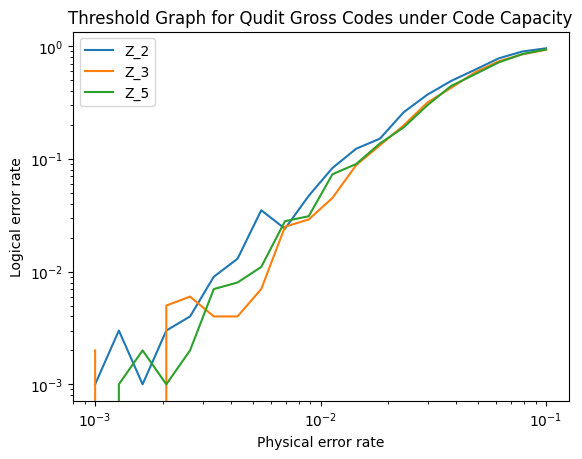

In [85]:
# Plotting

x = np.logspace(-3, -1, 20)
for d in range(3):
    plt.loglog(x, results_cap_qudit_gross[d])
plt.legend(['Z_2', 'Z_3', 'Z_5'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for Qudit Gross Codes under Code Capacity');

## Experiment 5: Circuit Level

In [112]:
results_circ_3 = np.array([0.1 , 0.08, 0.07, 0.09, 0.24, 0.25, 0.36, 0.42, 0.5 , 0.5 ])
results_circ_5 = np.array([0.12, 0.15, 0.37, 0.38, 0.33, 0.52, 0.56, 0.63, 0.69, 0.72])
results_circ_7 = np.array([0.28, 0.29, 0.4 , 0.39, 0.57, 0.61, 0.67, 0.72, 0.77, 0.74])

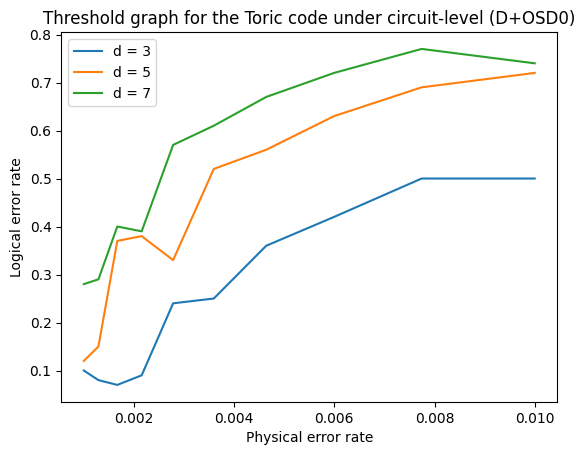

In [114]:
# BIG threshold graph

x = np.logspace(-3, -2, 10)

plt.plot(x, results_circ_3)
plt.plot(x, results_circ_5)
plt.plot(x, results_circ_7)

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(['d = 3', 'd = 5', 'd = 7'])
plt.title('Threshold graph for the Toric code under circuit-level (D+OSD0)');